# MNIST Dataset: Density Forests

In [1]:
'''Trains a simple convnet on the MNIST dataset.
Gets to 99.25% test accuracy after 12 epochs
(there is still a lot of margin for parameter tuning).
16 seconds per epoch on a GRID K520 GPU.
'''

from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import utils as np_utils
from keras import backend as K
import multiprocessing
import numpy as np
import matplotlib.pyplot as plt
from scipy.misc import imsave
import numpy as np
import time

# choose GPUs
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = ""

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

# custom libraries
from density_tree.density_forest import *
from density_tree.density_tree_create import *
from density_tree.density_tree_traverse import *
from density_tree.create_data import *
from density_tree.helpers import *
from density_tree.plots import *
from sklearn import decomposition
import warnings

# custom libraries
base_dir = '/raid/home/cwendl'  # for guanabana
import sys
sys.path.append(base_dir + '/SIE-Master/Zurich') # Path to density Tree package
sys.path.append(base_dir + '/SIE-Master/Code') # Path to density Tree package

# import libraries
from baselines.helpers import *
from baselines.plots import *
from helpers.data_augment import *
from helpers.helpers import get_y_pred_labels, get_accuracy_probas
from helpers.plots import *

/opt/conda/envs/python36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17838998880169467945
]


# Data Import 
Import the data, delete all data in the training set of class 7


In [2]:
# adapted from Source: https://github.com/keras-team/keras/tree/master/examples

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test_all, y_test_all) = mnist.load_data()
print(np.unique(y_train, return_counts=True))

label_to_remove = 7

# remove all trainig samples containing a label label_to_remove
x_train = x_train[y_train!=label_to_remove]
y_train = y_train[y_train!=label_to_remove]
    
x_test = x_test_all[y_test_all!=label_to_remove]
y_test = y_test_all[y_test_all!=label_to_remove]

# decrease all labels that are higher by -1 to avoid gaps
for i in range(label_to_remove+1, 11):
    y_train[y_train == i] = (i-1)
    y_test[y_test == i] = (i-1)
print(np.unique(y_train, return_counts=True))

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8), array([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949]))
(array([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype=uint8), array([5923, 6742, 5958, 6131, 5842, 5421, 5918, 5851, 5949]))


In [3]:
batch_size = 128
num_classes = 9
epochs = 5

# input image dimensions
img_rows, img_cols = 28, 28

# Reshape for Tensorflow
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
x_test_all = x_test_all.reshape(x_test_all.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_test_all = x_test_all.astype('float32')
x_train /= 255
x_test /= 255
x_test_all /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = np_utils.np_utils.to_categorical(y_train, num_classes)
y_test = np_utils.np_utils.to_categorical(y_test, num_classes)

x_train shape: (53735, 28, 28, 1)
53735 train samples
8972 test samples


In [4]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

print(model.summary())

model_train = False;
if model_train:
    model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
    model.save('mnist-weights.h5')
else :
    model = load_model('mnist-weights.h5')

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
__________

#### Make some predictions for the unseen class

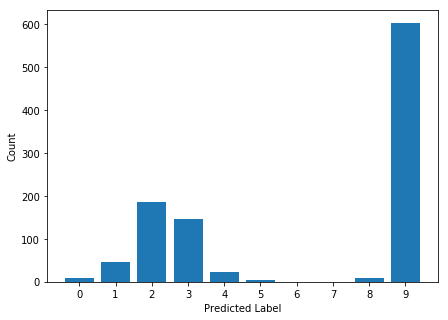

In [5]:
# all images in the test set containing a label label_to_remove
x_unseen_class = x_test_all[np.where(y_test_all==label_to_remove)[0]] 

# make prodictions for class unseen during training
y_pred = model.predict(x_unseen_class)
y_pred_label = get_y_pred_labels(y_pred, label_to_remove, background=False)

# distribution of predicted label
pred_labels, pred_counts = np.unique(y_pred_label,return_counts=True)

# visualization
fig = plt.figure(figsize=(7,5))
plt.bar(pred_labels, pred_counts)
plt.xticks(np.arange(0,10))
plt.xlabel("Predicted Label")
plt.ylabel("Count")
plt.savefig("../Figures/DF/pred-count.pdf", bbox_inches='tight', pad_inches=0)
plt.show()

In [6]:
# Avarage certitude for unseen class: 1-max_margin
c=get_accuracy_probas(y_pred)
    
pred_acc_mean = np.mean(c)
pred_acc_std = np.std(c)
    
print("Mean accuracy: %.2f %%" % (pred_acc_mean*100) )
print("Std accuracy: %.2f %%" % (pred_acc_std*100) )

pred_acc_high = .95 # 95 % is considered a very high confidence

pct = np.round(len(c[c>pred_acc_high])/len(c),4)*100
print("%.2f%% of all predictions made with an accuracy higher than %.2f%%" % (pct, pred_acc_high))

Mean accuracy: 66.72 %
Std accuracy: 32.16 %
28.40% of all predictions made with an accuracy higher than 0.95%


In [7]:
# Avarage certitude for seen class: 1-max_margin
y_pred_seen = model.predict(x_test)
y_pred_label_seen = get_y_pred_labels(y_pred_seen, label_to_remove, background=False)

c = get_accuracy_probas(y_pred_seen)
    
pred_acc_mean = np.mean(c)
pred_acc_std = np.std(c)
    
print("Mean accuracy: %.2f %%" % (pred_acc_mean*100) )
print("Std accuracy: %.2f %%" % (pred_acc_std*100) )

pred_acc_high = .95 # 95 % is considered a very high confidence

pct = np.round(len(c[c>pred_acc_high])/len(c),4)*100
print("%.2f %% of all predictions made with an accuracy higher than %.2f%%" % (pct, pred_acc_high))

Mean accuracy: 98.64 %
Std accuracy: 8.40 %
96.20 % of all predictions made with an accuracy higher than 0.95%


# Activation weights visualization

(1, 1, 24, 24, 64)


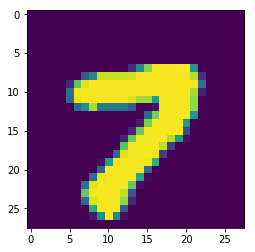

In [8]:
ind_im_test = 10
activations = get_activations(model, 1, x_unseen_class[ind_im_test][np.newaxis,:,:,:])
print(np.shape(activations))
plt.imshow(x_unseen_class[ind_im_test][:,:,0])
plt.show()

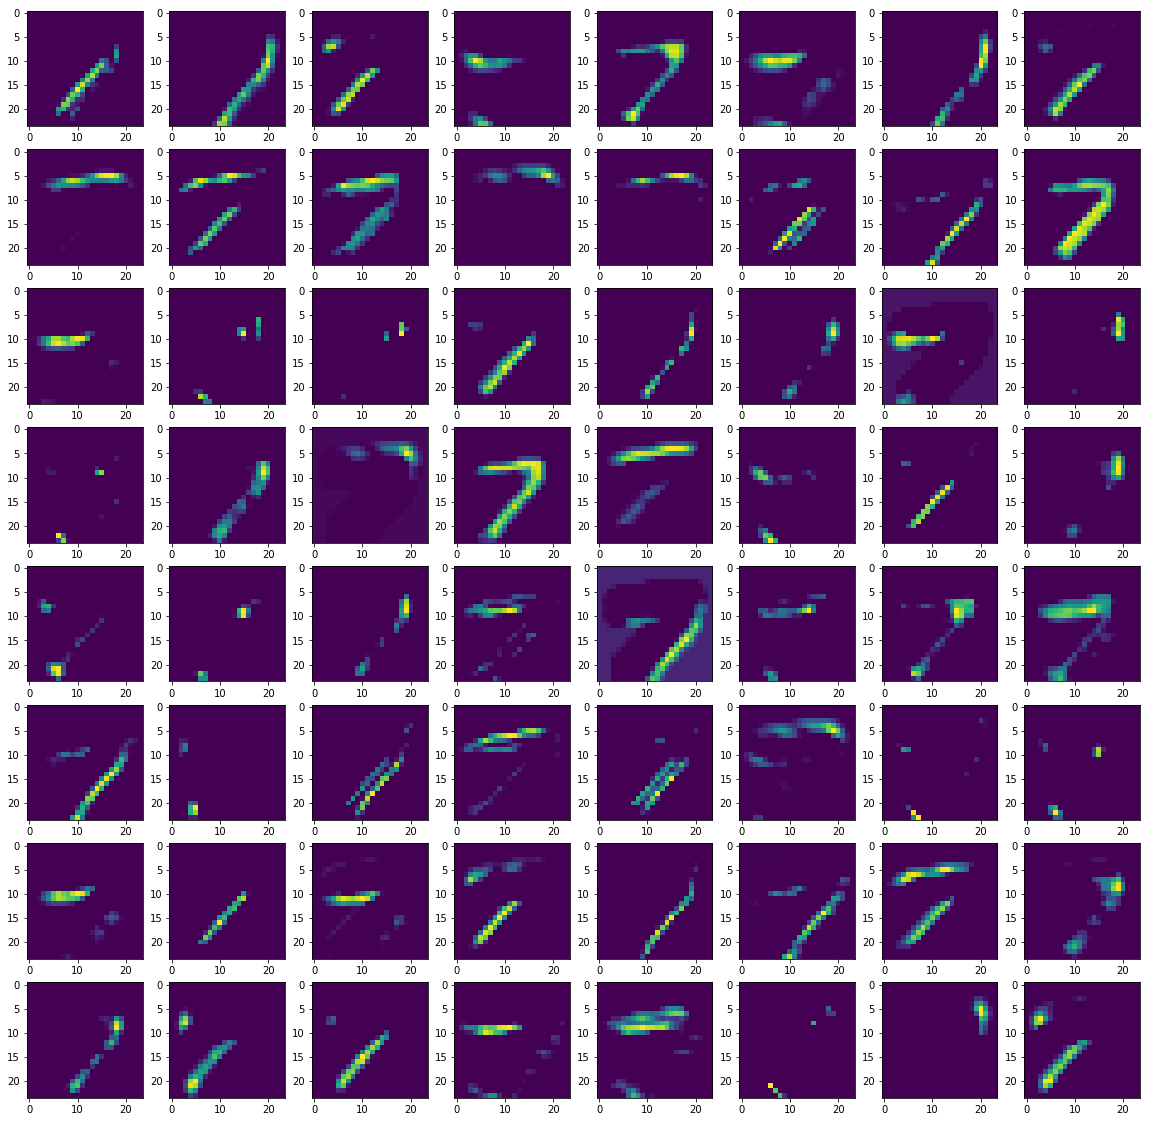

In [9]:
fig, axes = plt.subplots(8,8)
fig.set_size_inches(20,20)
for i in range(8):
    for j in range(8):
        axes[i][j].imshow(activations[0][0][:,:,i*8+j])
plt.show()

# Density Forest
## Get Activations, PCA, t-SNE

In [10]:
# get activation weights of last layer
act_unseen = get_activations(model, 6, x_unseen_class)[0]
print(np.shape(act_unseen))

n_points = 10000
act_train = get_activations(model, 6, x_train[:n_points])[0]
print(np.shape(act_train))

act_test = get_activations(model, 6, x_test_all)[0]
print(np.shape(act_test))

(1028, 128)
(10000, 128)
(10000, 128)


In [11]:
pts_per_class = 300
n_classes=10
dataset_subset_indices = get_balanced_subset_indices(y_test_all, np.arange(n_classes), pts_per_class)
np.shape(dataset_subset_indices)

(10, 300)

In [12]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=300)
# t-SNE visualization after PCA
tsne_all = tsne.fit_transform(act_test[np.concatenate(dataset_subset_indices)])

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3000 samples in 0.010s...
[t-SNE] Computed neighbors for 3000 samples in 1.362s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3000
[t-SNE] Computed conditional probabilities for sample 2000 / 3000
[t-SNE] Computed conditional probabilities for sample 3000 / 3000
[t-SNE] Mean sigma: 2.822100
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.918312
[t-SNE] Error after 300 iterations: 1.464642


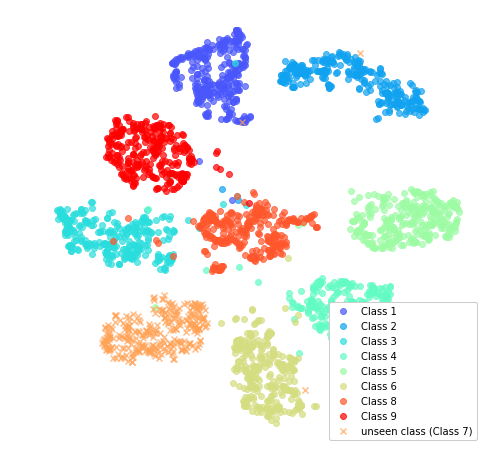

In [13]:
colors = plt.cm.rainbow(np.linspace(0,1,n_classes))[:,:3]*255
names = ['Class '+str(i) for i in range(10)]
classes_to_keep = np.asarray([x for x in range(1, n_classes) if x != label_to_remove])

# plot
plot_tsne(tsne_all, label_to_remove, classes_to_keep, pts_per_class, colors, names,
         s_name="../Figures/PCA/MNIST_t-SNE_before.pdf")

Explained variance ratio by first components:
[0.17267218 0.16218711 0.14576235 0.10569914 0.08063032 0.06132537
 0.04062817 0.03457721 0.01639362 0.01377384 0.01268609 0.00900125
 0.00847335 0.00783022 0.00708874]
Variance explained by first 15 components: 0.88


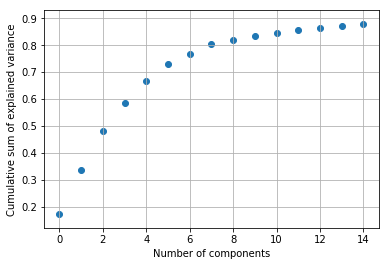

In [14]:
# create density tree for activation weights of training data

dimensions = act_train.shape[1]
nclusters = 9

# PCA
n_components = 15
plt.cla()
pca = decomposition.PCA(n_components=n_components)
pca.fit(act_train)
print("Explained variance ratio by first components:")
print(pca.explained_variance_ratio_)  
print("Variance explained by first %i components: %.2f" % (n_components, np.sum(pca.explained_variance_ratio_[:n_components])))
plt.scatter(np.arange(n_components), np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Number of components")
plt.ylabel("Cumulative sum of explained variance")
plt.grid()
plt.savefig("../Figures/DF/pca_components.pdf", bbox_inches='tight', pad_inches=0)
plt.show()

In [15]:
X_train = pca.transform(act_train)
X_test = pca.transform(act_test)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3000 samples in 0.004s...
[t-SNE] Computed neighbors for 3000 samples in 0.203s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3000
[t-SNE] Computed conditional probabilities for sample 2000 / 3000
[t-SNE] Computed conditional probabilities for sample 3000 / 3000
[t-SNE] Mean sigma: 1.999281
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.705826
[t-SNE] Error after 300 iterations: 1.388934


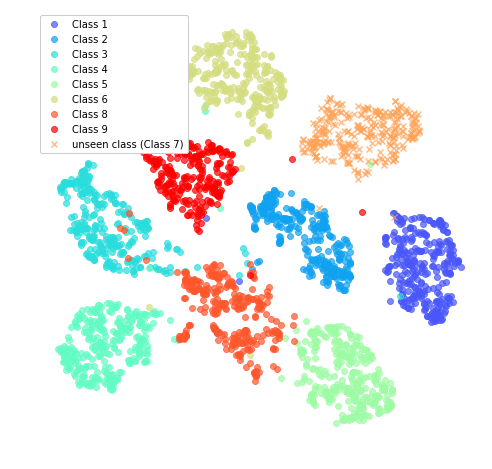

In [16]:
# t-SNE visualization after PCA
tsne_all = tsne.fit_transform(X_test[np.concatenate(dataset_subset_indices)])

# plot
plot_tsne(tsne_all, label_to_remove, classes_to_keep, pts_per_class, colors, names,
         s_name="../Figures/PCA/MNIST_t-SNE_after.pdf")

Next, we can plot the first three components to of the reduced data to search for clusters:

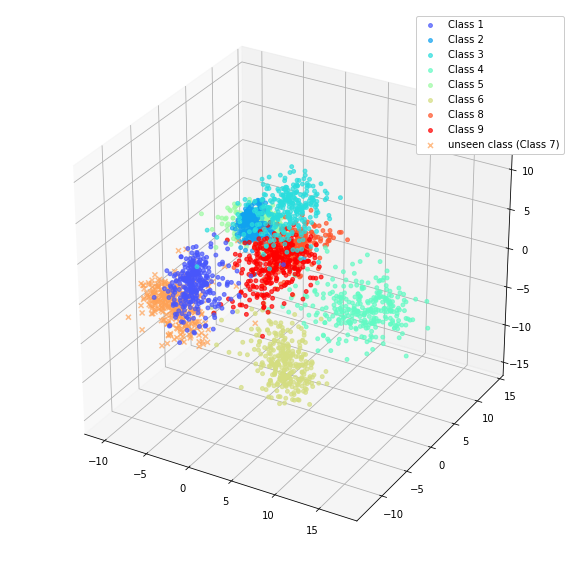

In [17]:
plot_pca(X_test, label_to_remove, classes_to_keep, names, dataset_subset_indices, colors)

Since only 54% of the variance is explained in the first 3 components the clusters are hard to discern.

## Create Density Forest

In [18]:
root_nodes_seen = density_forest_create(X_train, 4, min_subset=.15, n_trees=50, subsample_pct=.3, n_max_dim=5,
                                        n_jobs=-1, verbose=10, fact_improvement=.1)

Number of points on which to train each tree: 3000
Minimum number of points in each leaf: 450


[Parallel(n_jobs=40)]: Done   7 out of  50 | elapsed:    7.9s remaining:   48.7s
[Parallel(n_jobs=40)]: Done  13 out of  50 | elapsed:    8.3s remaining:   23.6s
[Parallel(n_jobs=40)]: Done  19 out of  50 | elapsed:    8.7s remaining:   14.2s
[Parallel(n_jobs=40)]: Done  25 out of  50 | elapsed:    8.9s remaining:    8.9s
[Parallel(n_jobs=40)]: Done  31 out of  50 | elapsed:    9.2s remaining:    5.6s
[Parallel(n_jobs=40)]: Done  37 out of  50 | elapsed:    9.4s remaining:    3.3s
[Parallel(n_jobs=40)]: Done  43 out of  50 | elapsed:   12.0s remaining:    2.0s


Number of created root nodes: 50
Mean number of clusters created per tree: 10


[Parallel(n_jobs=40)]: Done  50 out of  50 | elapsed:   12.7s finished


In [19]:
probas = density_forest_traverse(X_test, root_nodes_seen, thresh=.1)
probas = probas.flatten()

In [20]:
probas_seen = probas[y_test_all!=label_to_remove]
probas_unseen = probas[y_test_all==label_to_remove]

In [21]:
mean_proba_seen = np.nanmean(probas_seen)
mean_proba_unseen = np.nanmean(probas_unseen)

std_proba_seen = np.nanstd(probas_seen)
std_proba_unseen = np.nanstd(probas_unseen)

In [24]:
mag = 1e10
print("Mean probability of unseen class to belong to clusters: %.2f " % (mean_proba_unseen * mag))
print("Std probability of unseen class to belong to clusters: %.2f " % (std_proba_unseen * mag))

print("Mean probability of seen classes to belong to clusters: %.2f " % (mean_proba_seen * mag))
print("Std probability of seen classes to belong to clusters: %.2f " % (std_proba_seen * mag))

Mean probability of unseen class to belong to clusters: 0.16 
Std probability of unseen class to belong to clusters: 0.99 
Mean probability of seen classes to belong to clusters: 551021.20 
Std probability of seen classes to belong to clusters: 2924482.59 


In [25]:
print("Ratio unseen / seen: %.2f" % (mean_proba_unseen/mean_proba_seen))
print("Ratio seen / unseen: %.2f" % (mean_proba_seen/mean_proba_unseen))

Ratio unseen / seen: 0.00
Ratio seen / unseen: 3505493.20


In [26]:
ratios = [131311.77, 2580522513.30, 969.10, 1138792.35, _, _, _, _]

In [27]:
_, support = np.unique(y_test_all,return_counts = True)

In [28]:
y_pred = model.predict(x_test_all, verbose=1)
y_pred_label = get_y_pred_labels(y_pred, label_to_remove, background=False)

y_pred_acc = get_accuracy_probas(y_pred)

10000/10000 [==============================] - 2s 196us/step


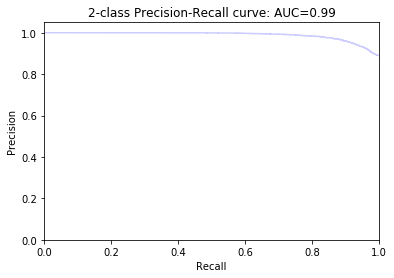

In [29]:
# Get precision, recall curve for test set using DF probabilities
# probability to be wrong
y_scores = probas
y_true = (y_test_all==y_pred_label)*1
y_true = y_true
y_scores = y_scores
precision, recall, thresholds = metrics.precision_recall_curve(y_true, y_scores)
plot_precision_recall(precision, recall)

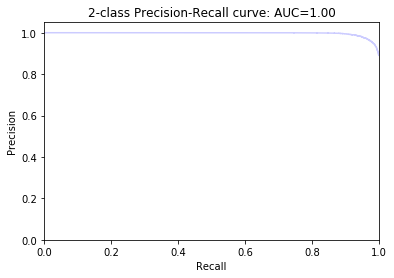

In [30]:
# Get precision, recall curve for test set using max margin
# max margin
y_pred_acc = g
y_scores = y_pred_acc
y_true = (y_test_all==y_pred_label)*1
y_true = y_true
y_scores = y_scores
precision, recall, thresholds = metrics.precision_recall_curve(y_true, y_scores)
plot_precision_recall(precision, recall)

In [1]:
np.argsort(y_pred_acc)

NameError: name 'np' is not defined